In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#Inspired by https://www.kaggle.com/code/mahmoudlimam/resampling-tutorial
# Importance measurement - f1 score (recall & precision)

y_col = "HeartDiseaseOrAttack"
colsToDrop = ["State"]

In [3]:
df = pd.read_csv('../data/heart_disease_health_indicators_BRFSS2021.csv')

for col in colsToDrop:
    df = df.drop(col, axis=1)

<AxesSubplot: xlabel='HeartDiseaseOrAttack', ylabel='count'>

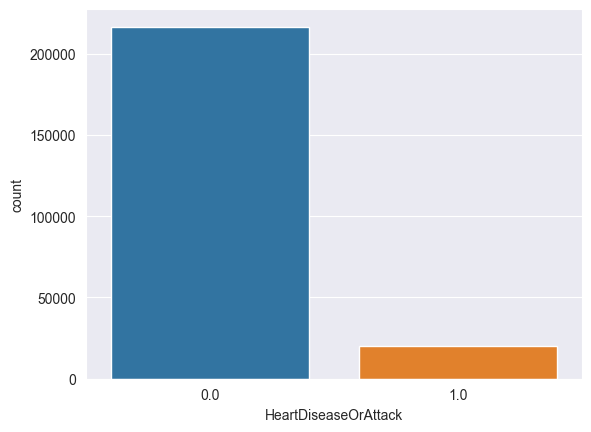

In [4]:
sns.countplot(data=df, x=y_col)

In [5]:
X = df.drop(y_col, axis=1)
y = df[y_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=45)

In [6]:
def train_evaluate(X_train, X_test, y_train, y_test, sampler=None, model=None, depth=12):

    if model is None:
        model = RandomForestClassifier(n_jobs=-1, max_depth=depth, class_weight="balanced_subsample", verbose=1, random_state=9)

    Xs_train, ys_train = X_train, y_train

    if sampler is not None:
        Xs_train, ys_train = sampler.fit_resample(X_train, y_train)

    model.fit(Xs_train, ys_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print("Training Results:\n")
    print(classification_report(y_train, y_pred_train))
    print("\n\nTesting Results:\n")
    print(classification_report(y_test, y_pred_test))

In [6]:
# Without re-sampling
train_evaluate(X_train, X_test, y_train, y_test, depth=6)

# With no re-sampling we get for test (max depth 6, default):
# Recall for 1.0: 0.01 --> 0.83
# Macro-Average F1: 0.48 --> 0.59


# 1 = 0.75, 0.58
# 2 = 0.78, 0.59
# 3 = 0.74, 0.59
# 6 = 0.83, 0.59 # High recall, low precision
# 10 = 0.8, 0.61
# 15 = 0.58, 0.65
# 20 = 0.31, 0.63
# 25 = 0.14, 0.58
# 50 = 0.06, 0.53

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Training Results:

              precision    recall  f1-score   support

         0.0       0.98      0.72      0.83    194844
         1.0       0.22      0.83      0.35     18283

    accuracy                           0.73    213127
   macro avg       0.60      0.78      0.59    213127
weighted avg       0.91      0.73      0.79    213127



Testing Results:

              precision    recall  f1-score   support

         0.0       0.98      0.73      0.83     21713
         1.0       0.22      0.83      0.34      1968

    accuracy                           0.74     23681
   macro avg       0.60      0.78      0.59     23681
weighted avg       0.92      0.74      0.79     23681



In [35]:
## -- Undersampling --

#Random Undersampling
from imblearn.under_sampling import RandomUnderSampler

sampler = RandomUnderSampler(random_state=11)

train_evaluate(X_train, X_test, y_train, y_test, sampler)

# Test Results:
# Recall for 1.0: 0.01 -> 0.83 --> 0.83
# Macro-Average F1: 0.48 -> 0.58 --> 0.59

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Training Results:

              precision    recall  f1-score   support

         0.0       0.99      0.74      0.85    194844
         1.0       0.25      0.92      0.39     18283

    accuracy                           0.76    213127
   macro avg       0.62      0.83      0.62    213127
weighted avg       0.93      0.76      0.81    213127



Testing Results:

              precision    recall  f1-score   support

         0.0       0.98      0.73      0.84     21713
         1.0       0.22      0.83      0.35      1968

    accuracy                           0.74     23681
   macro avg       0.60      0.78      0.59     23681
weighted avg       0.92      0.74      0.80     23681



In [36]:
import faiss

#https://towardsdatascience.com/k-means-8x-faster-27x-lower-error-than-scikit-learns-in-25-lines-eaedc7a3a0c8
# class FaissKMeans:
#     def __init__(self, n_clusters=8, n_init=10, max_iter=300):
#         self.n_clusters = n_clusters
#         self.n_init = n_init
#         self.max_iter = max_iter
#         self.kmeans = None
#         self.cluster_centers_ = None
#         self.inertia_ = None
#
#     def fit(self, X, y=None):
#         self.kmeans = faiss.Kmeans(d=X.shape[1],
#                                    k=self.n_clusters,
#                                    niter=self.max_iter,
#                                    nredo=self.n_init)
#         self.kmeans.train(X.astype(np.float32))
#         self.cluster_centers_ = self.kmeans.centroids
#         self.inertia_ = self.kmeans.obj[-1]
#
#     def predict(self, X):
#         return self.kmeans.index.search(X.astype(np.float32), 1)[1]
#
#     def get_params(self, deep=True):
#         out = dict()
#         out["n_clusters"] = self.n_clusters
#         out["n_init"] = self.n_init
#         out["max_iter"] = self.max_iter
#         return out
#
#     def set_params(self, **params):
#         for key, value in params.items():
#             setattr(self, key, value)
#         return self

In [37]:
# Cluster Centroid Undersampling
from imblearn.under_sampling import ClusterCentroids
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(verbose=1, batch_size=4096)
sampler = ClusterCentroids(estimator=kmeans)

train_evaluate(X_train, X_test, y_train, y_test, sampler)

# Test Results:
# Recall for 1.0: 0.01 -> 0.98
# Macro-Average F1: 0.48 -> 0.33

C:\VSCode\Uni\COM618-DataScience\Practice\01-ReadDataSet\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Init 1/3 with method k-means++


KeyboardInterrupt: 

In [132]:
## Oversampling

# Random Oversampling
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler(random_state=11)

train_evaluate(X_train, X_test, y_train, y_test, sampler)
# Test Results:
# Recall for 1.0: 0.01 -> 0.83 -> 0.70
# Macro-Average F1: 0.48 -> 0.59 -> 0.63

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Training Results:

              precision    recall  f1-score   support

         0.0       0.99      0.79      0.88    194844
         1.0       0.28      0.88      0.42     18283

    accuracy                           0.80    213127
   macro avg       0.63      0.83      0.65    213127
weighted avg       0.93      0.80      0.84    213127



Testing Results:

              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87     21713
         1.0       0.24      0.78      0.37      1968

    accuracy                           0.78     23681
   macro avg       0.61      0.78      0.62     23681
weighted avg       0.91      0.78      0.82     23681



In [8]:
#SMOTE Oversampling
from imblearn.over_sampling import SMOTE

sampler = SMOTE(k_neighbors=5, random_state=11)
train_evaluate(X_train, X_test, y_train, y_test, sampler)
# Test Results:
# Recall for 1.0: 0.01 -> 0.61 - 0.35
# Macro-Average F1: 0.48 -> 0.64 -> 0.65

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Training Results:

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94    194844
         1.0       0.38      0.45      0.41     18283

    accuracy                           0.89    213127
   macro avg       0.66      0.69      0.68    213127
weighted avg       0.90      0.89      0.89    213127



Testing Results:

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94     21713
         1.0       0.34      0.39      0.36      1968

    accuracy                           0.89     23681
   macro avg       0.64      0.66      0.65     23681
weighted avg       0.89      0.89      0.89     23681



In [7]:
# Borderline SMOTE
from imblearn.over_sampling import BorderlineSMOTE
sampler = BorderlineSMOTE(k_neighbors=5, random_state=11)

train_evaluate(X_train, X_test, y_train, y_test, sampler)
# Test Results:
# Recall for 1.0: 0.01 -> 0.59
# Macro-Average F1: 0.48 -> 0.64

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Training Results:

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94    194844
         1.0       0.38      0.47      0.42     18283

    accuracy                           0.89    213127
   macro avg       0.66      0.70      0.68    213127
weighted avg       0.90      0.89      0.89    213127



Testing Results:

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94     21713
         1.0       0.34      0.41      0.37      1968

    accuracy                           0.88     23681
   macro avg       0.64      0.67      0.65     23681
weighted avg       0.90      0.88      0.89     23681



In [40]:
from smote_variants import DBSMOTE
oversampler = DBSMOTE(min_samples=10)

train_evaluate(X_train, X_test, y_train, y_test, sampler)
# Test Results:
# Recall for 1.0: 0.01 -> 0.6
# Macro-Average F1: 0.48 -> 0.64

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Training Results:

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95    194844
         1.0       0.44      0.44      0.44     18283

    accuracy                           0.90    213127
   macro avg       0.69      0.69      0.69    213127
weighted avg       0.90      0.90      0.90    213127



Testing Results:

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94     21713
         1.0       0.36      0.35      0.35      1968

    accuracy                           0.90     23681
   macro avg       0.65      0.65      0.65     23681
weighted avg       0.89      0.90      0.89     23681



In [7]:
# Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scal = scaler.fit_transform(X_train)
X_train_scal = pd.DataFrame(X_train_scal, columns=X_train.columns)

X_test_scal = scaler.transform(X_test)
X_test_scal = pd.DataFrame(X_test_scal, columns=X_test.columns)

#df_scaled = scaler.fit_transform(df.to_numpy())
#df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

#X_scal = df.drop(y_col, axis=1)
#y_scal = df[y_col]

#X_scal_train, X_scal_test, y_scal_train, y_scal_test = train_test_split(X_scal, y_scal, test_size=0.1, random_state=45)

In [12]:
from sklearn.ensemble import HistGradientBoostingClassifier
model2 = HistGradientBoostingClassifier(class_weight='balanced')

train_evaluate(X_train_scal, X_test_scal, y_train, y_test, model=model2)
# With Scaling
# 0.83, 0.60

Training Results:

              precision    recall  f1-score   support

         0.0       0.98      0.74      0.85    194844
         1.0       0.24      0.84      0.37     18283

    accuracy                           0.75    213127
   macro avg       0.61      0.79      0.61    213127
weighted avg       0.92      0.75      0.80    213127



Testing Results:

              precision    recall  f1-score   support

         0.0       0.98      0.74      0.84     21713
         1.0       0.23      0.83      0.36      1968

    accuracy                           0.75     23681
   macro avg       0.60      0.79      0.60     23681
weighted avg       0.92      0.75      0.80     23681



In [9]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

X_clean = X.drop("DiabetesAge", axis=1)

toDrop = ["DiabetesAge"]

X_cat = X.drop(toDrop, axis=1)
X_cat["BMI"] =  pd.cut(X_cat["BMI"], [0,20,40,60,80,100], labels=[0, 1, 2, 3, 4] ,include_lowest=True)
X_cat["FruitsPerDay"] = pd.cut(X_cat["FruitsPerDay"], [0,0.5,1,2,4,8], labels=[0, 1, 2, 3, 4] ,include_lowest=True)
X_cat["DarkGreensPerDay"] = pd.cut(X_cat["DarkGreensPerDay"], [0,0.5,1,2,4, 8], labels=[0, 1, 2, 3, 4] ,include_lowest=True)
X_cat["PotatoesPerDay"] = pd.cut(X_cat["PotatoesPerDay"], [0, 0.25, 0.5,1,2,4, 8], labels=[0, 1, 2, 3, 4, 5] ,include_lowest=True)
X_cat["OtherVegPerDay"] = pd.cut(X_cat["OtherVegPerDay"], [0, 0.25, 0.5,1,2,4, 8], labels=[0, 1, 2, 3, 4, 5] ,include_lowest=True)
X_cat["BadMentalHealthLast30Days"] = pd.cut(X_cat["BadMentalHealthLast30Days"], [0, 5, 10, 15, 20, 25, 30], labels=[0, 1, 2, 3, 4, 5] ,include_lowest=True)
X_cat["BadPhysicalHealthLast30Days"] = pd.cut(X_cat["BadPhysicalHealthLast30Days"], [0, 5, 10, 15, 20, 25, 30], labels=[0, 1, 2, 3, 4, 5] ,include_lowest=True)

In [16]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y, test_size=0.3, random_state=109)

In [22]:
y_test_cat.isna().sum()

0

In [11]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn import metrics

def evalBayes(model, sampler=None):

    X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y, test_size=0.3, random_state=109)

    if(sampler):
        X_train_cat, y_train_cat = sampler.fit_resample(X_train_cat, y_train_cat)

    model.fit(X_train_cat, y_train_cat)

    y_pred_cat = model.predict(X_test_cat)

    print("Accuracy: ", metrics.accuracy_score(y_test_cat, y_pred_cat))

    print(classification_report(y_test_cat, y_pred_cat))

    return model

In [117]:
gnb = GaussianNB()

evalBayes(gnb)

Accuracy:  0.8091296820235632
              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89     65137
         1.0       0.25      0.62      0.35      5906

    accuracy                           0.81     71043
   macro avg       0.60      0.72      0.62     71043
weighted avg       0.90      0.81      0.84     71043



GaussianNB()

In [118]:
evalBayes(MultinomialNB())

Accuracy:  0.8578466562504399
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92     65137
         1.0       0.26      0.40      0.32      5906

    accuracy                           0.86     71043
   macro avg       0.60      0.65      0.62     71043
weighted avg       0.89      0.86      0.87     71043



MultinomialNB()

In [113]:
evalBayes(MultinomialNB())

Accuracy:  0.8578466562504399
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92     65137
         1.0       0.26      0.40      0.32      5906

    accuracy                           0.86     71043
   macro avg       0.60      0.65      0.62     71043
weighted avg       0.89      0.86      0.87     71043



In [121]:
evalBayes(ComplementNB())

Accuracy:  0.7499542530580071
              precision    recall  f1-score   support

         0.0       0.96      0.75      0.85     65137
         1.0       0.21      0.70      0.32      5906

    accuracy                           0.75     71043
   macro avg       0.59      0.73      0.58     71043
weighted avg       0.90      0.75      0.80     71043



ComplementNB()

In [124]:
evalBayes(BernoulliNB())

Accuracy:  0.851076108835494
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.92     65137
         1.0       0.28      0.49      0.36      5906

    accuracy                           0.85     71043
   macro avg       0.61      0.69      0.64     71043
weighted avg       0.89      0.85      0.87     71043



BernoulliNB()

In [125]:
evalBayes(CategoricalNB())

Accuracy:  0.8387314724884929
              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91     65137
         1.0       0.28      0.58      0.37      5906

    accuracy                           0.84     71043
   macro avg       0.62      0.72      0.64     71043
weighted avg       0.90      0.84      0.86     71043



CategoricalNB()

In [12]:
from sklearn.ensemble import HistGradientBoostingClassifier

sampler = SMOTE(k_neighbors=5, random_state=11)

hgbc = HistGradientBoostingClassifier()

evalBayes(hgbc, sampler)

Accuracy:  0.9178244161986403
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     65137
         1.0       0.52      0.13      0.21      5906

    accuracy                           0.92     71043
   macro avg       0.72      0.56      0.58     71043
weighted avg       0.89      0.92      0.89     71043



HistGradientBoostingClassifier()

In [29]:
rfc = RandomForestClassifier(n_jobs=-1, class_weight="balanced")

evalBayes(rfc, sampler)

Accuracy:  0.9048182086905113
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95     65137
         1.0       0.37      0.21      0.27      5906

    accuracy                           0.90     71043
   macro avg       0.65      0.59      0.61     71043
weighted avg       0.88      0.90      0.89     71043



RandomForestClassifier(class_weight='balanced', n_jobs=-1)

HighBP = 0.035156801595592466
HighChol = 0.026540922904230182
CholCheckLast5Years = 0.003331501708220229
BMI = 0.016017377953896076
Smoker = 0.0208253074554379
Stroke = 0.018693505913630337
Diabetes = 0.028860309299373922
PhysActivityLast30Days = 0.02118113856222956
FruitsPerDay = 0.055117158425379405
DarkGreensPerDay = 0.03466185772709701
PotatoesPerDay = 0.03918185055620058
OtherVegPerDay = 0.05700436130569891
HeavyDrinker = 0.008965395888510983
AnyHealthcare = 0.0042681872274195525
CantAffordHealthcare = 0.008654574442677218
GeneralHealth = 0.07826407427286368
BadMentalHealthLast30Days = 0.026951541706802074
BadPhysicalHealthLast30Days = 0.03142198911168612
DiffWalking = 0.02534027305972612
Sex = 0.024366387773956347
AgeGroup = 0.1265865156140546
HighestEducation = 0.05190178791461586
IncomeGroup = 0.09715931814569448
HighBPMeds = 0.053726573005597265
CholMeds = 0.10582128842940934


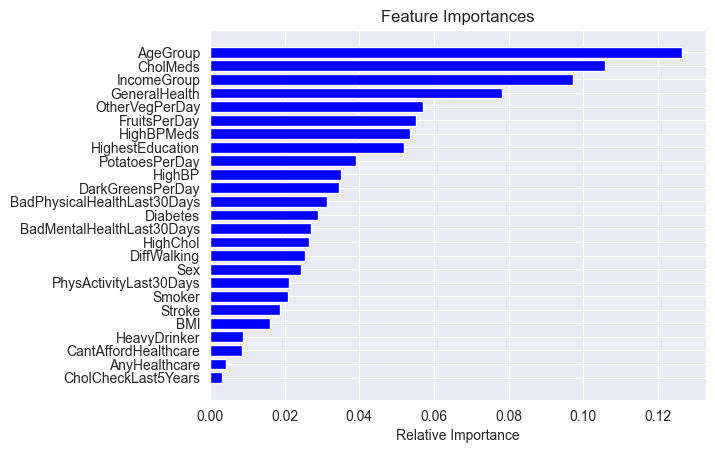

In [30]:
for name, importance in zip(X_cat.columns, rfc.feature_importances_):
    print(name, "=", importance)


features = X_cat.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()